[View in Colaboratory](https://colab.research.google.com/github/christianmerkwirth/colabs/blob/master/Understanding_Randomization_in_TF_Datasets.ipynb)

In [0]:
# Some boilerplate

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import functools
import numpy as np
import os
import random
import tensorflow as tf
import time

import matplotlib.pyplot as plt

%matplotlib inline
fig_width = 16
fig_height = 12

In [0]:
# This function will visualize the sample order encountered when iterating over
# a dataset. The input dataset is expected to provide the index or a batch of
# indices of the sample contained in the dataset. Each row of the plot
# shows the indices of the samples of a single batch as dark dots.

def visualize_dataset(dataset, show_plot=True, aspect_ratio=8):
  iter = dataset.make_one_shot_iterator()
  el = iter.get_next()
  all_batches = []
  n_cols = 0
  n_rows = 0
  with tf.Session() as sess:
    while True:
      try:
        single_batch = sess.run(el)
        all_batches.append(single_batch)
        n_cols = np.max([n_cols, np.max(single_batch)])
        n_rows += 1
      except:
        break  

  mat = np.zeros(shape = (n_rows, n_cols+1))
  
  for row, single_batch in enumerate(all_batches):
    mat[row, single_batch] += 1

  if show_plot:
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(mat, aspect=aspect_ratio)
    plt.xlabel('Sample index')
    plt.ylabel('Batch index')
    plt.show()    

**Next let's create a simple TF dataset without random shuffling. We can clearly see the 4 epochs.**

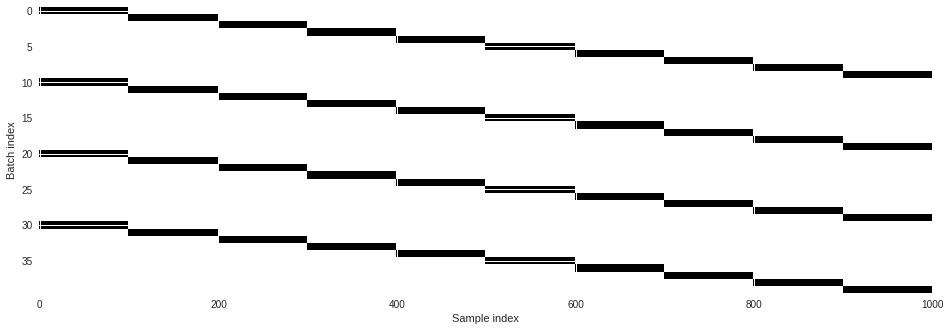

In [3]:
Nsamples = 1000
batch_size = 100
nr_epochs = 4

dataset = tf.data.Dataset.range(Nsamples)
# We repeat the dataset nr_epoch times.
dataset = dataset.repeat(nr_epochs)
dataset = dataset.batch(batch_size=batch_size)

visualize_dataset(dataset)

**Let's add random shuffling.**

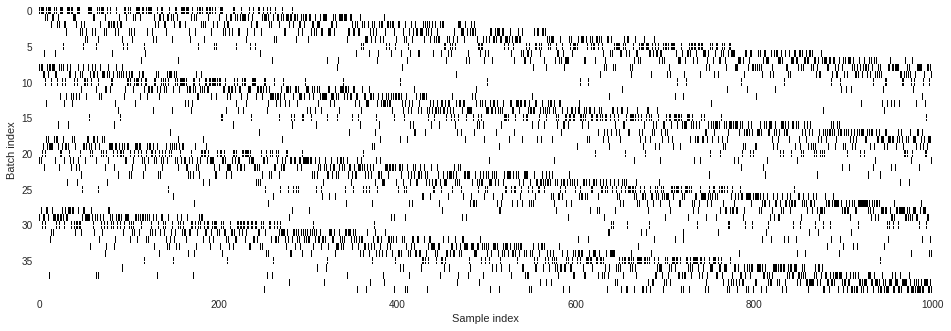

In [4]:
dataset = tf.data.Dataset.range(Nsamples)
dataset = dataset.repeat(nr_epochs)

dataset = dataset.shuffle(int(2 * batch_size))
dataset = dataset.batch(batch_size=batch_size)


visualize_dataset(dataset)

**That does not look very random. Function shuffle() is actually more a within-sliding-window permutation of samples. That's why there is the window size that has be specified. A small window size will prevent that samples that are very far spaced in the original data set will occur together in a batch.**

**Let's also shuffle the ordering of whole batches.**

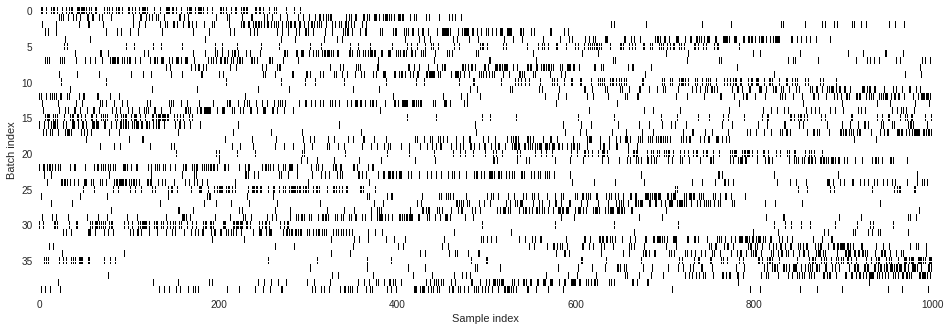

In [5]:
dataset = tf.data.Dataset.range(Nsamples)
dataset = dataset.repeat(nr_epochs)
dataset = dataset.shuffle(int(2 * batch_size))
dataset = dataset.batch(batch_size=batch_size)

# This now shuffles whole batches.
dataset = dataset.shuffle(10)

visualize_dataset(dataset)


**How does this look like if we only shuffle whole batches ?**

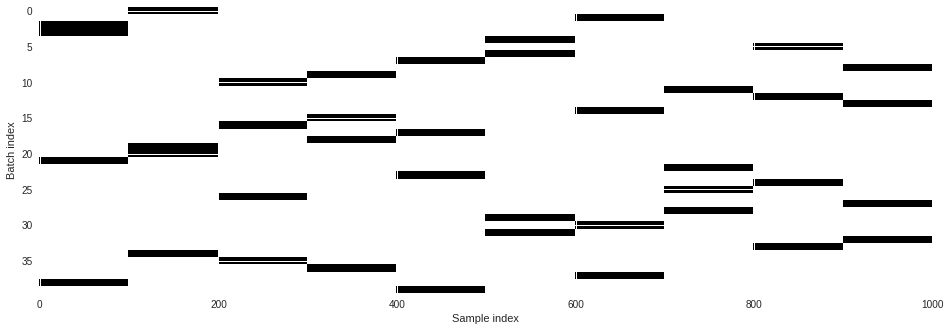

In [6]:
Nsamples = 1000
batch_size = 100
nr_epochs = 4

dataset = tf.data.Dataset.range(Nsamples)
# We repeat the dataset nr_epoch times.
dataset = dataset.repeat(nr_epochs)
dataset = dataset.batch(batch_size=batch_size)
dataset = dataset.shuffle(10)

visualize_dataset(dataset)


**Create TFRecords just containing sample index. Note that we randomly route samples to different shards.**

In [0]:
# Create sharded set of TFRecord files with sample index as payload.

class TFRecordGenerator(object):
  def __init__(self, num_shards=10):
    self.num_shards = num_shards

  def _pick_output_shard(self):
    return random.randint(0, self.num_shards-1)

  def generate_records(self, num_samples, tfrecord_file_name):
    writers = []
    for i in range(self.num_shards):
      writers.append(
        tf.python_io.TFRecordWriter("%s-%05i-of-%05i" % (tfrecord_file_name, i,
                                                           self.num_shards)))  
    counter = 0    
    for index in range(num_samples):
      example = tf.train.Example(features = tf.train.Features(feature = {
        'index': tf.train.Feature(int64_list = tf.train.Int64List(value = [index])),
      }))
      writers[self._pick_output_shard()].write(example.SerializeToString())
      counter += 1

    # Close all files
    for w in writers:
      w.close()
    print("%d records writen" % counter)
    
# Standalone function to parse a serialized example record into an index.
def _parse_tfexample_fn(tfrecord, mode=None):
  # Extract features using the keys set during creation
  features = {'index': tf.FixedLenFeature([], tf.int64) }
  # Extract the data record
  sample = tf.parse_single_example(tfrecord, features)
  # And extract the scalar sample index from the dict.
  index = sample['index']
  return index
    

In [8]:
# Remove any old files to prevent interference.
!rm tfrecords-*

t = TFRecordGenerator(num_shards=10)
t.generate_records(10000, 'tfrecords')

# How many shard were written to disk ?

!ls -la tfrecords-* | wc -l

10000 records writen
10


**Now let's read those shards with randomized samples into a TFRecordDataset, even using interleaving
to further randomize sample order**

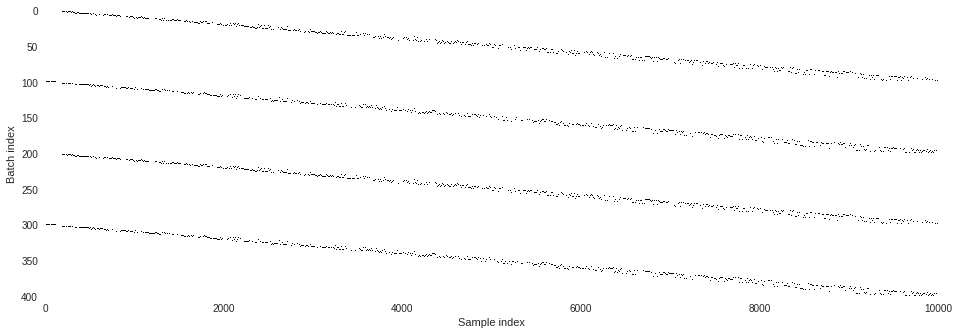

In [9]:
tfrecord_pattern = 'tfrecords-?????-of-?????'

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(tfrecord_pattern)
# Make sure to fully shuffle the list of tfrecord files.
dataset = dataset.shuffle(buffer_size=1000)

# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = dataset.interleave(
    tf.data.TFRecordDataset,
    cycle_length=10,
    block_length=1)
# Here we convert raw protobufs into a structs.
dataset = dataset.map(
    functools.partial(_parse_tfexample_fn, mode=None),
    num_parallel_calls=10)
dataset = dataset.repeat(4)
dataset = dataset.batch(100)

visualize_dataset(dataset)

**Something went super wrong. Why again samples are processed almost perfectly in order despite
we wrote them to random shards ?**

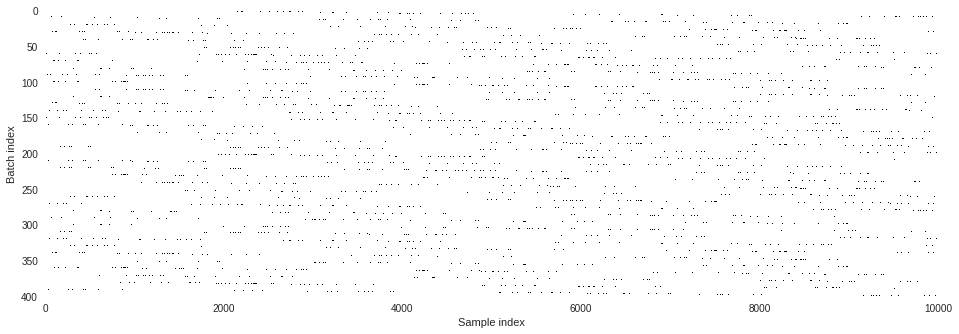

In [10]:
tfrecord_pattern = 'tfrecords-?????-of-?????'

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(tfrecord_pattern)
# Make sure to fully shuffle the list of tfrecord files.
dataset = dataset.shuffle(buffer_size=1000)

# Preprocesses each files consecutively.
dataset = dataset.interleave(
    tf.data.TFRecordDataset,
    cycle_length=1,
    block_length=1)
# Here we convert raw protobufs into a structs.
dataset = dataset.map(
    functools.partial(_parse_tfexample_fn, mode=None),
    num_parallel_calls=10)
dataset = dataset.repeat(4)
dataset = dataset.batch(100)

visualize_dataset(dataset)

**So actually the parallel processing which should support randomization reintroduces unwanted order. With cycle_length=1 things are a bit better. But still we see a lot of regularity in the sample ordering. Let's use shuffling to further randomize.**

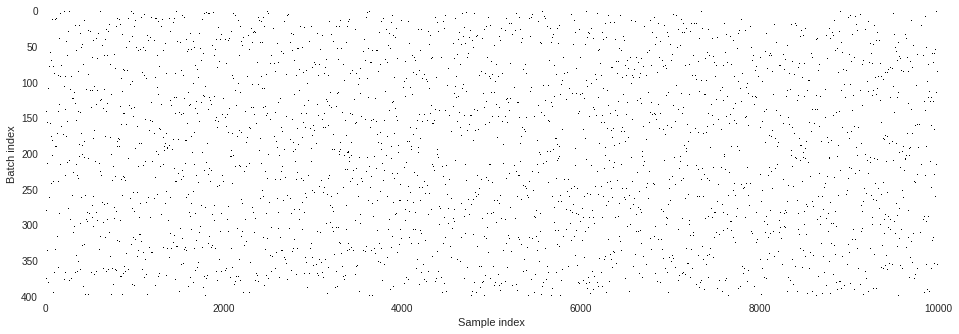

In [11]:
tfrecord_pattern = 'tfrecords-?????-of-?????'

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(tfrecord_pattern)
# Make sure to fully shuffle the list of tfrecord files.
dataset = dataset.shuffle(buffer_size=1000)

# Preprocesses each files consecutively.
dataset = dataset.interleave(
    tf.data.TFRecordDataset,
    cycle_length=1,
    block_length=1)
# Here we convert raw protobufs into a structs.
dataset = dataset.map(
    functools.partial(_parse_tfexample_fn, mode=None),
    num_parallel_calls=10)
dataset = dataset.repeat(4)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(100)

visualize_dataset(dataset)

**Okay, let's put more randomness into the tfrecord dataset on disk. Write more shards.**

In [12]:
# Remove any old files to prevent interference.
!rm tfrecords-*

t = TFRecordGenerator(num_shards=1000)
t.generate_records(10000, 'tfrecords')

# How many shard were written to disk ?

!ls -la tfrecords-* | wc -l

10000 records writen
1000


**Now reading in with cycle_length > 1 looks much more random. **

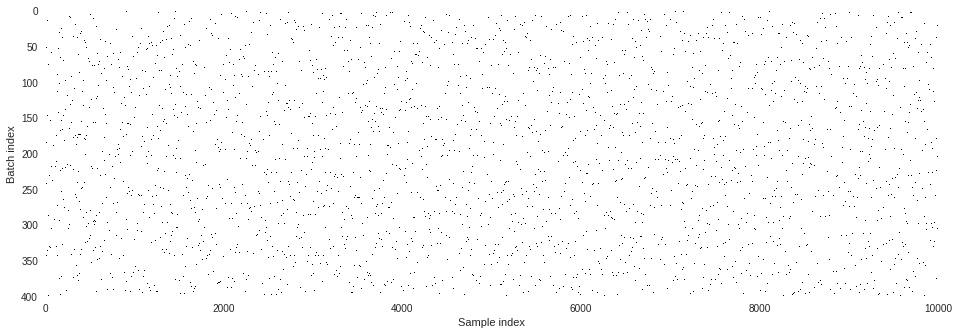

In [13]:
tfrecord_pattern = 'tfrecords-?????-of-?????'

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(tfrecord_pattern)
# Make sure to fully shuffle the list of tfrecord files.
dataset = dataset.shuffle(buffer_size=1000)

# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = dataset.interleave(
    tf.data.TFRecordDataset,
    cycle_length=10,
    block_length=1)
# Here we convert raw protobufs into a structs.
dataset = dataset.map(
    functools.partial(_parse_tfexample_fn, mode=None),
    num_parallel_calls=10)
dataset = dataset.repeat(4)
dataset = dataset.batch(100)

visualize_dataset(dataset)

**But can we rewrite the dataset to be more random ?**

In [0]:
 # Rewrite and randomize a TF record dataset without parsing raw protobufs.
  
def pick_output_shard(num_shards):
    return random.randint(0, num_shards-1)
  
def rerandomize_tfrecords(in_tfrecord_file_pattern, out_tfrecord_file_name, num_shards):
    writers = []
    for i in range(num_shards):
      writers.append(
        tf.python_io.TFRecordWriter("%s-%05i-of-%05i" % (out_tfrecord_file_name, i,
                                                         num_shards)))  

    dataset = tf.data.TFRecordDataset.list_files(in_tfrecord_file_pattern)
    # Make sure to fully shuffle the list of tfrecord files. These are only
    # relatively short strings, so shuffling them in memory is not that expensive.
    dataset = dataset.shuffle(buffer_size=10000)
    # Do not process concurrently, but interleaves records from each file into a single, unified dataset.
    dataset = dataset.interleave(
        tf.data.TFRecordDataset,
        cycle_length=1,
        block_length=1)
    # And use a large, memory-demanding shuffle buffer.
    dataset = dataset.shuffle(20000)
    iter = dataset.make_one_shot_iterator()
    el = iter.get_next()

    with tf.Session() as sess:
      while True:
        try:
          example = sess.run(el)
          writers[pick_output_shard(num_shards)].write(example) # .SerializeToString()      
        except:
          break 

    # Close all files
    for w in writers:
      w.close()

# This function will permute samples within a shard before moving on to the next
# shard. The number of shards in the output fileset is the same as in the input
# filset. This function is slow for large number of input shards.
def permute_records_inside_shard(in_tfrecord_file_pattern, shuffle_buffer_length=1000):
    filename_ds = tf.data.TFRecordDataset.list_files(in_tfrecord_file_pattern)
    filename_iter = filename_ds.make_one_shot_iterator()
    next_file = filename_iter.get_next()
    with tf.Session() as sess:
      while True:
        try:
          filename = sess.run(next_file)     
        except tf.errors.OutOfRangeError:
          break    
        
        outfilename = os.path.join(os.path.dirname(filename),
                                   "rr_" + os.path.basename(filename))
        
        print('Rewriting %s to %s' % (filename, outfilename))
        dataset = tf.data.TFRecordDataset(filename)
        # And use a large, memory-demanding shuffle buffer.
        dataset = dataset.shuffle(shuffle_buffer_length)
        iter = dataset.make_one_shot_iterator()
        el = iter.get_next()
        with tf.python_io.TFRecordWriter(outfilename) as writer:
          while True:
            try:
              example = sess.run(el)
              writer.write(example)      
            except tf.errors.OutOfRangeError:
              break        


In [15]:
!rm rr_tfrecords-*
#%time permute_records_inside_shard('tfrecords-?????-of-?????')
%time rerandomize_tfrecords('tfrecords-?????-of-?????', 'rr_tfrecords', 1000)
!ls -la rr_tfrecords-* | wc -l

CPU times: user 3.69 s, sys: 489 ms, total: 4.18 s
Wall time: 3.12 s
1000


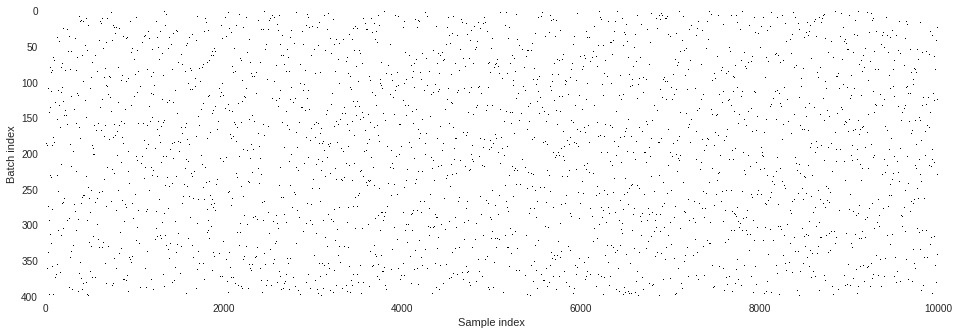

In [16]:
tfrecord_pattern = 'rr_tfrecords-?????-of-?????'

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(tfrecord_pattern)
# Make sure to fully shuffle the list of tfrecord files.
dataset = dataset.shuffle(buffer_size=1000)

# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = dataset.interleave(
    tf.data.TFRecordDataset,
    cycle_length=10,
    block_length=1)
# Here we convert raw protobufs into a structs.
dataset = dataset.map(
    functools.partial(_parse_tfexample_fn, mode=None),
    num_parallel_calls=10)
dataset = dataset.repeat(4)
dataset = dataset.batch(100)

visualize_dataset(dataset)

 **That looks really good by now. Still, let's add shuffling to make it virtually impossible that we ever encounter
 exactly the same batch again.**

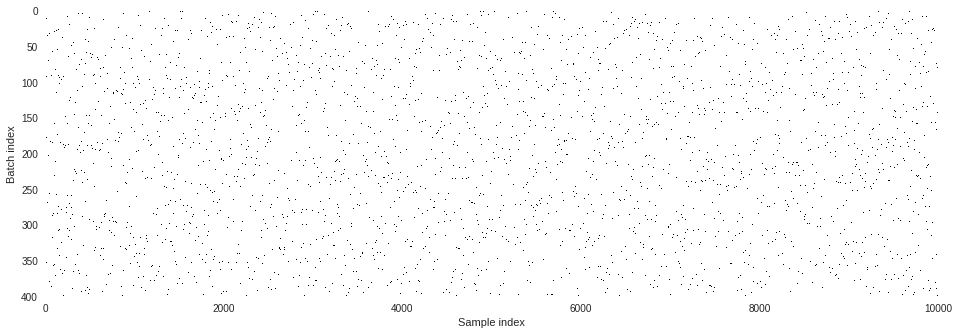

In [17]:
tfrecord_pattern = 'rr_tfrecords-?????-of-?????'

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(tfrecord_pattern)
# Make sure to fully shuffle the list of tfrecord files.
dataset = dataset.shuffle(buffer_size=1000)

# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = dataset.interleave(
    tf.data.TFRecordDataset,
    cycle_length=10,
    block_length=1)
# Here we convert raw protobufs into a structs.
dataset = dataset.map(
    functools.partial(_parse_tfexample_fn, mode=None),
    num_parallel_calls=10)
dataset = dataset.repeat(4)
dataset = dataset.shuffle(2000)
dataset = dataset.batch(100)
dataset = dataset.shuffle(20)

visualize_dataset(dataset)